In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import re
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

### Setup and Data Preparation

In [2]:
data_path = './data/'
df = pd.read_csv(data_path + 'FinancialPB.csv',header=None ,encoding='ISO-8859-1')
df.columns =['sentiment' ,'statement']
df.head()

,sentiment,statement
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
df.drop_duplicates(subset=['statement'],keep='first',inplace=True)
df.shape

(4838, 2)

### Dataset EDA

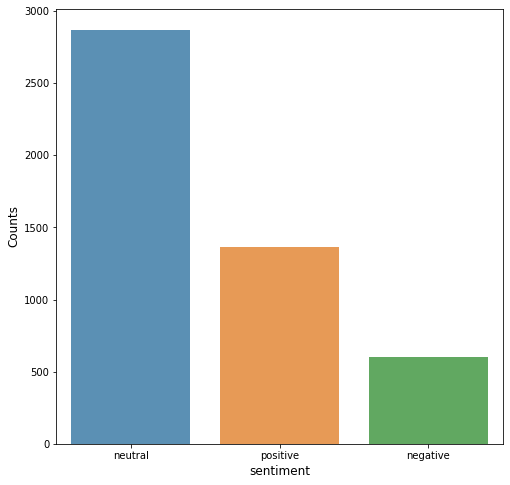

In [4]:
plt.figure(figsize=(8,8))
sns.barplot(df['sentiment'].value_counts().index, df['sentiment'].value_counts().values, alpha=0.8)
plt.ylabel('Counts', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks()
plt.show();

In [5]:
df['sentiment_encoded'] = LabelEncoder().fit_transform(df['sentiment'])
df.head()

,sentiment,statement,sentiment_encoded
0,neutral,"According to Gran , the company has no plans t...",1
1,neutral,Technopolis plans to develop in stages an area...,1
2,negative,The international electronic industry company ...,0
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


### Baseline Model

In [6]:
#stopwords removal
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taojin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Clean the Text

In [7]:
#remove punctuations
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def remove_stopwords(text, STOPWORDS):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def stem_words(text, stemmer):
    return " ".join([stemmer.stem(word) for word in text.split()])

def remove_freqwords(text, FREQWORDS):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

def lemmatize_words(text, lemmatizer, wordnet_map ):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

def clean_review(text):
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in stop:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    return clean_text

def join_text(text):
    return " ".join(text)

In [8]:
df['statement'] = df['statement'].apply(lambda x: remove_punct(x))
STOPWORDS = set(", ".join(stopwords.words('english')))
df['non_stop_statement'] = df['statement'].apply(lambda x: remove_stopwords(x, STOPWORDS))

In [9]:
df['stemmed_statement'] = df['non_stop_statement'].apply(lambda x: stem_words(x,PorterStemmer()))

In [10]:
#remove frequent words 
fre_count = Counter()
for phrase in df["stemmed_statement"].values:
    for word in phrase.split():
        fre_count[word] += 1
        
fre_count.most_common(10)

[('the', 6059),
 ('of', 3199),
 ('in', 2747),
 ('and', 2587),
 ('to', 2493),
 ('eur', 1310),
 ('for', 1150),
 ('it', 999),
 ('compani', 967),
 ('is', 920)]

In [11]:
fre_words = set([word for (word, count) in fre_count.most_common(10)])
df["non_freq_statement"] = df["stemmed_statement"].apply(lambda x: remove_freqwords(x, fre_words))


In [13]:
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
df["lemmatized_statesment"] = df["non_freq_statement"].apply(lambda x: lemmatize_words(x, WordNetLemmatizer(), wordnet_map))

In [14]:
df.head()

,sentiment,statement,sentiment_encoded,non_stop_statement,stemmed_statement,non_freq_statement,lemmatized_statesment
0,neutral,According to Gran the company has no plans to...,1,According to Gran the company has no plans to ...,accord to gran the compani ha no plan to move ...,accord gran ha no plan move all product russia...,accord gran ha no plan move all product russia...
1,neutral,Technopolis plans to develop in stages an area...,1,Technopolis plans to develop in stages an area...,technopoli plan to develop in stage an area of...,technopoli plan develop stage an area no less ...,technopoli plan develop stage an area no less ...
2,negative,The international electronic industry company ...,0,The international electronic industry company ...,the intern electron industri compani elcoteq h...,intern electron industri elcoteq ha laid off t...,intern electron industri elcoteq ha lay off te...
3,positive,With the new production plant the company woul...,2,With the new production plant the company woul...,with the new product plant the compani would i...,with new product plant would increas capac mee...,with new product plant would increas capac mee...
4,positive,According to the company s updated strategy fo...,2,According to the company updated strategy for ...,accord to the compani updat strategi for the y...,accord updat strategi year baswar target longt...,accord updat strategi year baswar target longt...


In [17]:
df1 = df.drop(['sentiment','statement','non_stop_statement','stemmed_statement','non_freq_statement'],axis =1)
df1.head()

,sentiment_encoded,lemmatized_statesment
0,1,accord gran ha no plan move all product russia...
1,1,technopoli plan develop stage an area no less ...
2,0,intern electron industri elcoteq ha lay off te...
3,2,with new product plant would increas capac mee...
4,2,accord updat strategi year baswar target longt...


In [18]:
x_train,x_test,y_train,y_test = train_test_split(df.lemmatized_statesment,df.sentiment_encoded,test_size = 0.2 , random_state = 42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3870,), (968,), (3870,), (968,))

In [25]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("Baseline MODEL - LOGISTIC REGRESSION")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

Baseline MODEL - LOGISTIC REGRESSION
accuracy: 76.45%
[[ 60  42  18]
 [  8 523  44]
 [  3 113 157]]
              precision    recall  f1-score   support

           0       0.85      0.50      0.63       120
           1       0.77      0.91      0.83       575
           2       0.72      0.58      0.64       273

    accuracy                           0.76       968
   macro avg       0.78      0.66      0.70       968
weighted avg       0.77      0.76      0.75       968



In [26]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("MULTINOMIAL NAIVE BAYES")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

MULTINOMIAL NAIVE BAYES
accuracy: 70.97%
[[ 19  71  30]
 [  1 562  12]
 [  0 167 106]]
              precision    recall  f1-score   support

           0       0.95      0.16      0.27       120
           1       0.70      0.98      0.82       575
           2       0.72      0.39      0.50       273

    accuracy                           0.71       968
   macro avg       0.79      0.51      0.53       968
weighted avg       0.74      0.71      0.66       968



In [41]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.075,
                                                   n_estimators = 100,
                                                   max_depth = 8,
                                                   random_state=42))])




model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("GRADIENT BOOST")
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

GRADIENT BOOST
accuracy: 78.2%
[[ 71  37  12]
 [  9 516  50]
 [  3 100 170]]
              precision    recall  f1-score   support

           0       0.86      0.59      0.70       120
           1       0.79      0.90      0.84       575
           2       0.73      0.62      0.67       273

    accuracy                           0.78       968
   macro avg       0.79      0.70      0.74       968
weighted avg       0.78      0.78      0.78       968

